# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


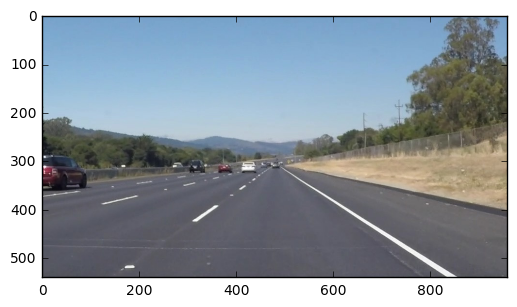

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

last_mean_left_slope = []
last_mean_right_slope = []
last_mean_left_intercept = []
last_mean_right_intercept = []
last_left_line = None
last_right_line = None

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_noise(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def get_slope(x1, y1, x2, y2):
    return ((y2-y1)/(x2-x1))

def get_intercept(x, y, slope):
    return y - slope*x

def draw_lane_lines(img, lines, vertices, color=[0, 0, 255], thickness=10):
    """
    Get the average slope for the left and right lane lines and 
    combine all of the lines passed in into two distinct lane lines
    """
    left_line = []
    right_line = []
    global last_mean_left_slope
    global last_mean_right_slope
    global last_mean_left_intercept
    global last_mean_right_intercept
    global last_left_line
    global last_right_line
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = get_slope(x1, y1, x2, y2)
            intercept = get_intercept(x1, y1, slope)
            # TODO: Only append slopes in a given tolerance
            if slope < 0:
                # Draw Hough Lines to Debug
                #cv2.line(img, (x1, y1), (x2, y2), [0, 255, 0], 3)
                if slope > -.8 and slope < -.5:
                    left_line.append((slope, intercept))
            else:
                # Draw Hough Lines to Debug
                #cv2.line(img, (x1, y1), (x2, y2), [0, 255, 0], 3)
                if slope < .8 and slope > .5:
                    right_line.append((slope, intercept))
    mean_left_slope = np.mean([line[0] for line in left_line])
    if last_mean_left_slope:
        if len(last_mean_left_slope) > 149:
            last_mean_left_slope.pop(0)
        last_mean_left_slope.append(mean_left_slope)
        mean_left_slope = sum(last_mean_left_slope)/len(last_mean_left_slope)
    mean_left_intercept = np.mean([line[1] for line in left_line])
    if last_mean_left_intercept:
        if len(last_mean_left_intercept) > 149:
            last_mean_left_intercept.pop(0)
        last_mean_left_intercept.append(mean_left_intercept)
        mean_left_intercept = sum(last_mean_left_intercept)/len(last_mean_left_intercept)
    mean_right_slope = np.mean([line[0] for line in right_line])
    if last_mean_right_slope:
        if len(last_mean_right_slope) > 149:
            last_mean_right_slope.pop(0)
        last_mean_right_slope.append(mean_right_slope)
        mean_right_slope = sum(last_mean_right_slope)/len(last_mean_right_slope)
    mean_right_intercept = np.mean([line[1] for line in right_line])
    if last_mean_right_intercept:
        if len(last_mean_right_intercept) > 149:
            last_mean_right_intercept.pop(0)
        last_mean_right_intercept.append(mean_right_intercept)
        mean_right_intercept = sum(last_mean_right_intercept)/len(last_mean_right_intercept)

    try:
        y1_right = vertices[0][3][1]
        x1_right = int(round((y1_right - mean_right_intercept)/mean_right_slope))

        y2_right = vertices[0][2][1]
        x2_right = int(round((y2_right - mean_right_intercept)/mean_right_slope))

        y1_left = vertices[0][0][1]
        x1_left = int(round((y1_left - mean_left_intercept)/mean_left_slope))

        y2_left = vertices[0][1][1]
        x2_left = int(round((y2_left - mean_left_intercept)/mean_left_slope))
        
        last_left_line = [x1_left, y1_left, x2_left, y2_left]
        last_right_line = [x1_right, y1_right, x2_right, y2_right]
        cv2.line(img, (x1_right, y1_right), (x2_right, y2_right), color, thickness)
        cv2.line(img, (x1_left, y1_left), (x2_left, y2_left), color, thickness)
    except:
        pass
#         if last_left_line and last_right_line:
#             x1_left, y1_left, x2_left, y2_left = last_left_line
#             x1_right, y1_right, x2_right, y2_right = last_right_line
#             cv2.line(img, (x1_right, y1_right), (x2_right, y2_right), color, thickness)
#             cv2.line(img, (x1_left, y1_left), (x2_left, y2_left), color, thickness)

def draw_lines(img, lines, color=[255, 0, 0], thickness=3):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, vertices):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #draw_lines(line_img, lines)
    draw_lane_lines(line_img, lines, vertices)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['challenge.png',
 'challenge2.png',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

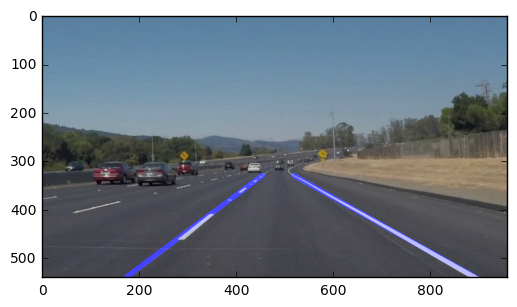

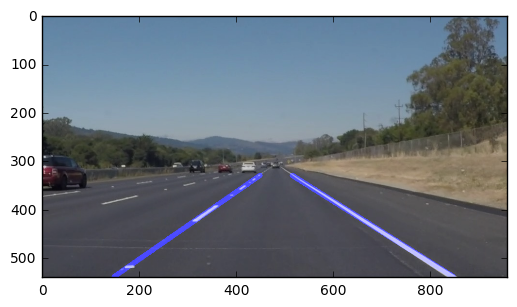

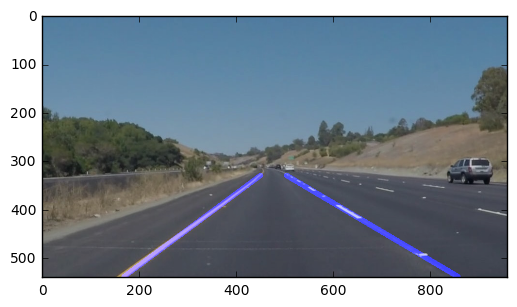

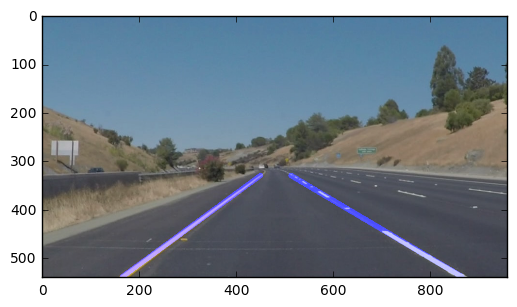

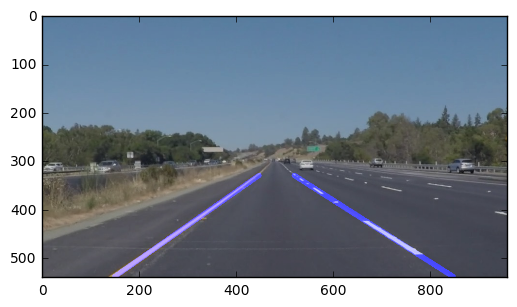

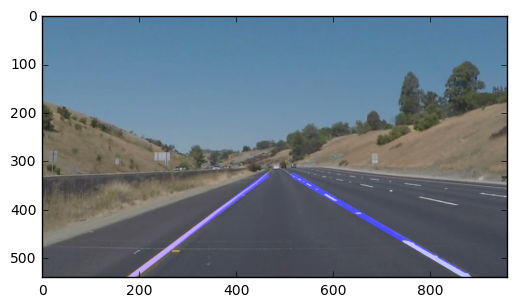

In [5]:
# Test pipeline on images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

def readImage(imagePath):
    image = (mpimg.imread(imagePath))
    #print('This image is: ', type(image), 'with dimensions:', image.shape)
    return image

def process_image(image):
    # Define pipeline parameters
    ysize = image.shape[0]
    xsize = image.shape[1]
    kernel = 7
    ratio = 3
    lowThreshold = 50
    rho = 2
    theta = np.pi/270
    threshold = 50
    min_line_length = 100
    max_line_gap = 500
    img_alpha = 0.8
    img_beta = 1.
    img_lambda = 0.
    vertices = np.array([[(0,ysize-1),
                          (((xsize/2.)-40), (ysize/2.)+60), 
                          (((xsize/2.)+40), (ysize/2.)+60), 
                          (xsize-1,ysize-1)]], dtype=np.int32)
    # Convert to gray scale
    gray = grayscale(image)
    # Apply gaussian blur
    blur = gaussian_noise(gray, kernel)
    # Apply the Canny transformation
    canny_image = canny(blur, lowThreshold,lowThreshold*ratio)
    # Select a region of interest
    region_select = region_of_interest(canny_image, vertices)
    # Detect Hough lines
    color_edges = hough_lines(region_select, rho, theta, 
                              threshold, min_line_length, 
                              max_line_gap, vertices)
    # Overlay the lines on the original image
    lines_edges = weighted_img(color_edges, image, α=img_alpha, 
                               β=img_beta, λ=img_lambda)
    
    return lines_edges

for imagePath in ["test_images/solidWhiteCurve.jpg",
                  "test_images/solidWhiteRight.jpg",
                  "test_images/solidYellowCurve.jpg",
                  "test_images/solidYellowCurve2.jpg",
                  "test_images/solidYellowLeft.jpg",
                  "test_images/whiteCarLaneSwitch.jpg"]:

    image = readImage(imagePath)
    lines_edges = process_image(image)
    plt.figure()
    plt.imshow(lines_edges)


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
# Test pipeline on video
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

def process_image(image):
    # Define pipeline parameters
    ysize = image.shape[0]
    xsize = image.shape[1]
    kernel = 7
    ratio = 3
    lowThreshold = 50
    rho = 2
    theta = np.pi/270
    threshold = 50
    min_line_length = 100
    max_line_gap = 500
    img_alpha = 0.8
    img_beta = 1.
    img_lambda = 0.
    vertices = np.array([[(0,ysize-1),
                          ((xsize/2-50), ysize/2+60), 
                          ((xsize/2+50), ysize/2+60), 
                          (xsize-1,ysize-1)]], dtype=np.int32)
    # Convert to gray scale
    gray = grayscale(image)
    # Apply gaussian blur
    blur = gaussian_noise(gray, kernel)
    # Apply the Canny transformation
    canny_image = canny(blur, lowThreshold,lowThreshold*ratio)
    # Select a region of interest
    region_select = region_of_interest(canny_image, vertices)
    # Detect Hough lines
    color_edges = hough_lines(region_select, rho, theta, 
                              threshold, min_line_length, 
                              max_line_gap, vertices)
    # Overlay the lines on the original image
    lines_edges = weighted_img(color_edges, image, α=img_alpha, 
                               β=img_beta, λ=img_lambda)
    
    return lines_edges

Let's try the one with the solid white lane on the right first ...

In [8]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:02<00:00, 80.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 2.37 s, sys: 549 ms, total: 2.92 s
Wall time: 3.13 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P0_example1.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [10]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:08<00:00, 80.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 7.47 s, sys: 1.74 s, total: 9.21 s
Wall time: 8.84 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Conclusion
### Process
I started out by exploring color detection to extract only the lane lines based on their RGB values, but quickly realized that this is prone to a lot of variation due to many external conditions including lighting, road surface, weather, and more. I quickly realized that it was important to look for other methods that were slightly more predictable, and that could be tuned more easily to different environments.

With this in mind, I began exploring edge detection and found the initial results much more robust to changing conditions. 

The process I followed was:
1. Convert source image to grayscale.
2. Apply Gaussian Blur
3. Apply the Canny transformation
4. Select an appropriate region of interest
5. Compute Hough Lines from the Canny image based on the region of interest
6. Partition Hough Lines by slope to separate out the right and left lines.
7. Average the slope and intercept from the right and left lines.
8. Use the averaged values to draw the final lane lines over the original image.

My initial pipeline focused mainly on tuning the parameters that were passed into the Canny and Hough transformations to get the best results possible. I finally settled on values that seem to work across a wide range of conditions. In addition to tuning it was also important to filter the hough lines and choose only line segments in a certain slope range to combine into the final result. This was necessary because small outliers with near 0 slope produce a lot of noise and throw off the average slope calculations causing the drawn lane lines to be drastically skewed towards the center of the image for some frames. My current result captures a good approximation of the lane lines for the images, videos, and challenge problems. It currently updates every frame, and while fairly accurate, the result tends to look a little noisy due to the frame by frame variance in the line segments. I have a few good ideas for smoothing the final result which I hope to explore more in depth.

### Challenges
Most of the challenges that I ran into stem from the fact that it is difficult to choose one set of values that will 
be true in all conditions. I think that it is important to come up with a base line set of values that generalize well across multiple images, but then it is also important to find ways to adapt those values iteratively and not keep them static for every situation. Color Selection proved difficult because there is not one set of global RGB values that always corresponds to lane lines. Lane Lines that are yellow or white may vary significantly in value based on weather, lighting, or the age or condition of the road surface. Depending on the materials used to construct the road, the contrast between the road and the lane markings can also be widely different both on a single paved surface, but also as you travel between freeways to highways and inner city, or neighborhood driving. In addition to the road surface the lane markings can be spaced and constructed really differently in different cities or countries, all highlighting the need to test the model on a wider set of data. The sample data that I used to construct this model, consists of only a handful of images and videos. To go beyond the simple lane detector that I have constructed for this project, it would be extremely important to test any lane detection algorithm on a much larger data set.

Hough Lines proved to be a fairly robust lane finding method given the sample data we were working from, but I think there is a lot of room for improvement through finding ways to adaptively update the settings, of the canny and hough transforms based on lighting conditions and contrast of road surface to lane markings. While it is possible to find parameters that generalize relatively well to all conditions, I feel strongly that there must be a better way to adaptively tune the algorithm on the fly to keep from overly underfitting the data in an attempt to handle all cases.
Region Selection is another area that I think could be expanded to adapt to different grades and curves as the road surface changes. In the end another challenge with the final result is the fact that it is updating every frame causing a lot of noise in the drawn over lane lines. I think one important aspect to pursue further, that would immediately improve the result would be to store and average the slope calculations over several frames. This would help keep the lane lines from looking like they are popping so much and give a much more smooth interpolation between frames. I hope to explore these and many other ideas as I refine my lane detection process.

### Future Exploration
This was a really fun project, but I feel like I have just scratched the tip of the iceberg. I have so many ideas that I am excited about pursuing further, and can't wait to start gathering more of my own driving video to test the algorighm against. Some of the main areas of future exploration that excite me include:
1. Gathering more data and testing assumptions under lots of different conditions.
2. Exploring Color Spaces and digging much deeper into the role color could play in partitioning the drivable space.
3. Labeling data and evaluating the correctness of the calculated lines against the labels. 
4. Smoothing calculated lane lines over several frames to reduce noise.
5. Breaking up lane lines into multiple segments instead of just one continuous line to better follow curves.
6. Treating this as a Supervised Learning problem and using labeled video such as that in P1_example.mp4 to find best set of parameters based on labeled data. I'd like to explore the possibility of using gradient descent to reduce RMSE between the labeled data and calculated data and to tune the parameters of the Canny and Hough transforms.
7. Developing strategies to do adaptive filtering based on various road and weather conditions.

Overall, I am enthusiastic about the potential that computer vision has for doing lane detection, and I am really excited to continue to explore and see what other ideas might arise as I dig deeper into these challenges. 



## Submission

If you're satisfied with your video outputs it's time to submit!


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [12]:
def process_image(image):
    # Define pipeline parameters
    ysize = image.shape[0]
    xsize = image.shape[1]
    kernel = 7
    ratio = 2
    lowThreshold = 50
    rho = 2
    theta = np.pi/270
    threshold = 50
    min_line_length = 100
    max_line_gap = 500
    img_alpha = 0.8
    img_beta = 1.
    img_lambda = 0.
    vertices = np.array([[(0,ysize-1),
                          ((xsize/2-50), ysize/2+80), 
                          ((xsize/2+50), ysize/2+80), 
                          (xsize-1,ysize-1)]], dtype=np.int32)
    # Convert to gray scale
    gray = grayscale(image)
    # Apply gaussian blur
    blur = gaussian_noise(gray, kernel)
    # Apply the Canny transformation
    canny_image = canny(blur, lowThreshold,lowThreshold*ratio)
    # Select a region of interest
    region_select = region_of_interest(canny_image, vertices)
    # Detect Hough lines
    color_edges = hough_lines(region_select, rho, theta, 
                              threshold, min_line_length, 
                              max_line_gap, vertices)
    # Overlay the lines on the original image
    lines_edges = weighted_img(color_edges, image, α=img_alpha, 
                               β=img_beta, λ=img_lambda)
    
    return lines_edges

In [13]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:07<00:00, 35.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 5.53 s, sys: 1.36 s, total: 6.89 s
Wall time: 7.94 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

## Challenge
I was excited to see that the initial pipeline I developed for the sample videos worked fairly well on the challenge as well. While there is much more variability in the curvature of the road, in the color of the road surface, and in the overall noise in the surrounding areas, the image pipeline was still able to approximate the lane lines surprisingly well throughout most of the video. Specific areas where it falls down are at approximately 0:04s into the video when the road surface drastically changes color all of a sudden. Also due to the strong curvature of the road the lane lines are approximating a good tangent to the overall lane line but they don't follow it's overall curvature.

In order to improve on the current pipeline I think it would be interesting to explore breaking up the single line segments based on region of interest, then taking the average slope in each region and stitching these together to create a final result made up of multiple line segments to more accurately follow the curvature of the road. I also think it would be interesting to explore color spaces more deeply in order to solve the issue with rapidly changing road surface color. I am confident that these and many more challenges can be overcome by testing and tuning the pipeline on a larger more diverse training set representative of a wider range of driving conditions.